In [103]:
import os
import shutil
from PIL import Image
import numpy as np
import scipy as sp
from scipy.spatial import distance
import time
from tqdm import tqdm_notebook

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Device configuration
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
#NVIDIA GT 630M - 2.1 <= 3.0 !!! cuDNN error: CUDNN_STATUS_ARCH_MISMATCH
device = torch.device('cpu')
device

device(type='cpu')

In [34]:
dir_ = "data"
market_path_train = "/Market-1501-v15.09.15/bounding_box_train"
market_path_test = "/Market-1501-v15.09.15/bounding_box_test"
market_path_query = "/Market-1501-v15.09.15/query"
dist_market_path_train = "/trainClasses"
dist_market_path_test = "/testClasses"
dist_market_path_query = "/queryClasses"
dist_market_path_smallTest = "/smallTest"
dist_market_path_smallQuery = "/smallQuery"
#files_train = os.listdir(dir_ + market_path_train)
#files_test = os.listdir(dir_ + market_path_test)
#files_query = os.listdir(dir_ + market_path_query)

#### Разделить на классы

In [10]:
for file in files_train:
    path_ = dir_ + dist_market_path_train + '/' + file.split('_')[0]
    if not os.path.exists(path_):
        os.makedirs(path_)
    shutil.copy(dir_ + market_path_train + '/' + file, path_ + '/' + file)
    
for file in files_test:
    path_ = dir_ + dist_market_path_test + '/' + file.split('_')[0]
    if not os.path.exists(path_):
        os.makedirs(path_)
    shutil.copy(dir_ + market_path_test + '/' + file, path_ + '/' + file)

for file in files_query:
    path_ = dir_ + dist_market_path_query + '/' + file.split('_')[0]
    if not os.path.exists(path_):
        os.makedirs(path_)
    shutil.copy(dir_ + market_path_query + '/' + file, path_ + '/' + file)

In [12]:
for i, name in enumerate(os.listdir(dir_ + dist_market_path_smallTest)):
    os.rename(dir_ + dist_market_path_smallTest + '/' + name,
              dir_ + dist_market_path_smallTest + '/' + str("{:04d}".format(i)))

for i, name in enumerate(os.listdir(dir_ + dist_market_path_query)):
    os.rename(dir_ + dist_market_path_query + '/' + name,
              dir_ + dist_market_path_query + '/' + str("{:04d}".format(i)))

for i, name in enumerate(os.listdir(dir_ + dist_market_path_train)):
    os.rename(dir_ + dist_market_path_train + '/' + name,
              dir_ + dist_market_path_train + '/' + str("{:04d}".format(i)))

In [3]:
def load_train_dataset(path, batch_size=1, shuffle=False):
    data_path = dir_ + path
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transforms.Compose([
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ToTensor()
        ])
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=shuffle
    )
    return train_loader

In [4]:
def load_test_dataset(path, batch_size=1, shuffle=False):
    data_path = dir_ + path
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=torchvision.transforms.ToTensor()
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=shuffle
    )
    return train_loader

In [5]:
train_loader = load_train_dataset(dist_market_path_train, batch_size=1000, shuffle=True)

In [7]:
test_loader = load_test_dataset(dist_market_path_smallTest, batch_size=1, shuffle=False)
query_loader = load_test_dataset(dist_market_path_smallQuery, batch_size=1, shuffle=False)

### Test for Model

In [56]:
def find_distance_one(object_with_features, test_features):
    list_dist = []
    for index in tqdm_notebook(range(len(test_features))):
        dist_ = distance.cosine(object_with_features[1], test_features[index][1])
        list_dist.append((test_features[index][0], dist_, index))
    list_dist.sort(key=lambda tup: tup[1])
    result = (object_with_features[0], list_dist, object_with_features[2])
    return result

In [28]:
def find_distance_all(query_features, test_features):
    result = []
    for i in tqdm_notebook(range(len(query_features))):
        distances_for_object = find_distance_one(object_with_features=query_features[i],
                                                 test_features=test_features)
        result.append(distances_for_object)
    return result

In [29]:
def mAP(rangs, path_="data/testClasses/"):
    #{ { str_path, { {str_path_r_1, p_r_1}, {str_path_r_2, p_r_2}, .. {str_path_r_n, p_r_1} } }, ... }
 
    len_rangs = len(rangs) #751
    print(len_rangs)
    sum_mAP = 0

    for rang in rangs:
        person = str(rang[0])
        len_person = len(os.listdir(path_ + str("{:0>4s}".format(person)) + '/'))
        sum_P = 0
        sum_true = 0
        i = 0
        for rang_r in rang[1]:
            i += 1
            if rang_r[0] == person:
                sum_true += 1
                sum_P += sum_true/i
            #print("Person: ", person, rang_r[0].split('_')[0], sum_true/i)
        #print("Person:", person, "len_person:", str(len_person), "AP =", sum_P/len_person)
        sum_mAP += sum_P/len_person
    return sum_mAP/len_rangs

In [48]:
def test_model(model, test_loader, query_loader, path_):
    test_features = []
    print("Waiting output from test_loader...")
    with torch.no_grad():
        for images, labels in test_loader:
            outputs2, outputs1 = model(images)
            test_features.append((str(labels.tolist()[0]), outputs1, images[0].numpy()))
    len(test_features)

    query_features = []
    print("Waiting output from query_loader...")
    with torch.no_grad():
        for images, labels in query_loader:
            outputs2, outputs1 = model(images)
            query_features.append((str(labels.tolist()[0]), outputs1, images[0].numpy()))
    len(query_features)
    
    rangs = find_distance_all(query_features=query_features, test_features=test_features)
    return mAP(rangs=rangs, path_=path_)

### Model

In [12]:
#inplace = 3 - кол-во входных каналов (RGB)

class CNN_ReID(nn.Module):
    def __init__(self, inplanes=3, planes1=8, planes2=16, planes3=32, stride=1):
        super(CNN_ReID, self).__init__()

        self.layer1 = nn.Sequential(nn.Conv2d(inplanes, planes1, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2)) 
        self.layer2 = nn.Sequential(nn.Conv2d(planes1, planes2, kernel_size=3, stride=1, padding=1), 
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(nn.Conv2d(planes2, planes3, kernel_size=3, stride=1, padding=1), 
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2)) 
        #self.drop_out = nn.Dropout() 
        self.fc1 = nn.Linear(16 * 8 * planes3, 128) # 16*8*32 = 4096
        self.fc2 = nn.Linear(128, 751) # 16*8*32 = 4096
    def forward(self, x): 
        out = self.layer1(x) 
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        #out = self.drop_out(out)
        out1 = self.fc1(out)
        out2 = self.fc2(out1)
        return out2, out1

In [23]:
def trainModel(num_epochs=10, weight_decay=0.001, momentum=0.9, learning_rate=0.01, name="model_0.ckpt"):
    model = CNN_ReID().to(device)
    criterion = nn.CrossEntropyLoss() # CrossEntropyLoss() объединяет и SoftMax, и кросс-энтропийную функцию потерь
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)

    total_step = len(train_loader)
    loss_list = []
    acc_list = []

    best_mAP = -1
    
    print("wd =",weight_decay, "momentum =", momentum, "lr = ", learning_rate)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device) 
            labels = labels.to(device)

            # Прямой запуск
            outputs2, outputs1 = model(images)
            loss = criterion(outputs2, labels)
            loss_list.append(loss.item())

            # Обратное распространение и оптимизатор
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Отслеживание точности
            total = labels.size(0)
            _, predicted = torch.max(outputs2.data, 1)
            correct = (predicted == labels).sum().item()
            acc_list.append(correct / total)
            
            if (i + 1) % (total_step-1) == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.8f}%'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                              (correct / total)))
                
        new_mAP = test_model(model=model)
        if (new_mAP >= best_mAP):
            bestModel = model
            best_mAP = new_mAP
            bestEpoch = epoch
            print("bestModel was found! mAP: {:.4f}, epoch: {:d}".format(best_mAP, bestEpoch))
                
                
    print("LOSS =", loss.item(), "wd =", weight_decay, "momentum =",
          momentum, "lr =", learning_rate, "best_mAP =", best_mAP, "bestEpoch =", bestEpoch)
    
    # Save the model checkpoint
    torch.save(bestModel.state_dict(), name)

In [24]:
start_time = time.time()
trainModel(num_epochs=50, weight_decay=0.001, momentum=0.9, learning_rate=0.05, name="model_Test_F_MAP_1.ckpt")
print("Time = ", time.time() - start_time)

wd = 0.001 momentum = 0.9 lr =  0.05
Epoch [1/50], Step [12/13], Loss: 6.6087, Accuracy: 0.00100000%
449
bestModel was found! mAP: 0.1372, epoch: 0
Epoch [2/50], Step [12/13], Loss: 6.5722, Accuracy: 0.00700000%
449
Epoch [3/50], Step [12/13], Loss: 6.5194, Accuracy: 0.00700000%
449
bestModel was found! mAP: 0.1375, epoch: 2
Epoch [4/50], Step [12/13], Loss: 6.4697, Accuracy: 0.00300000%
449
Epoch [5/50], Step [12/13], Loss: 6.3593, Accuracy: 0.01600000%
449
Epoch [6/50], Step [12/13], Loss: 6.1145, Accuracy: 0.03100000%
449
Epoch [7/50], Step [12/13], Loss: 5.7078, Accuracy: 0.03700000%
449
Epoch [8/50], Step [12/13], Loss: 5.4264, Accuracy: 0.05900000%
449
bestModel was found! mAP: 0.1433, epoch: 7
Epoch [9/50], Step [12/13], Loss: 5.0175, Accuracy: 0.08400000%
449
bestModel was found! mAP: 0.1576, epoch: 8
Epoch [10/50], Step [12/13], Loss: 4.8111, Accuracy: 0.09200000%
449
bestModel was found! mAP: 0.1717, epoch: 9
Epoch [11/50], Step [12/13], Loss: 4.8366, Accuracy: 0.09700000%
44

In [26]:
start_time = time.time()
trainModel(num_epochs=60, weight_decay=0.001, momentum=0.9, learning_rate=0.03, name="model_Test_F_MAP_2.ckpt")
print("Time = ", time.time() - start_time)

wd = 0.001 momentum = 0.9 lr =  0.03
Epoch [1/60], Step [12/13], Loss: 6.6180, Accuracy: 0.00300000%
449
bestModel was found! mAP: 0.1347, epoch: 0
Epoch [2/60], Step [12/13], Loss: 6.5869, Accuracy: 0.00000000%
449
bestModel was found! mAP: 0.1367, epoch: 1
Epoch [3/60], Step [12/13], Loss: 6.5732, Accuracy: 0.00200000%
449
bestModel was found! mAP: 0.1388, epoch: 2
Epoch [4/60], Step [12/13], Loss: 6.4959, Accuracy: 0.01000000%
449
Epoch [5/60], Step [12/13], Loss: 6.3643, Accuracy: 0.01400000%
449
Epoch [6/60], Step [12/13], Loss: 6.1621, Accuracy: 0.01900000%
449
Epoch [7/60], Step [12/13], Loss: 5.8648, Accuracy: 0.04000000%
449
Epoch [8/60], Step [12/13], Loss: 5.5932, Accuracy: 0.04300000%
449
Epoch [9/60], Step [12/13], Loss: 5.4300, Accuracy: 0.05600000%
449
bestModel was found! mAP: 0.1445, epoch: 8
Epoch [10/60], Step [12/13], Loss: 5.0729, Accuracy: 0.06700000%
449
bestModel was found! mAP: 0.1570, epoch: 9
Epoch [11/60], Step [12/13], Loss: 4.8754, Accuracy: 0.09500000%
44

### Test

In [27]:
model = CNN_ReID()
model.load_state_dict(torch.load("model_Test_F_MAP_1.ckpt"))
model.eval()

CNN_ReID(
  (layer1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=751, bias=True)
)

In [43]:
test_loader = load_test_dataset(dist_market_path_test, batch_size=1, shuffle=False)
query_loader = load_test_dataset(dist_market_path_query, batch_size=1, shuffle=False)

In [49]:
test_model(model=model, test_loader=test_loader, query_loader=query_loader, path_="data/testClasses/")

Waiting output from test_loader...
Waiting output from query_loader...


3368


0.21375719315704386

In [51]:
test_features = []
print("Waiting output from test_loader...")
with torch.no_grad():
    for images, labels in test_loader:
        outputs2, outputs1 = model(images)
        test_features.append((str(labels.tolist()[0]), outputs1, images[0].numpy()))
len(test_features)

Waiting output from test_loader...


13115

In [52]:
query_features = []
print("Waiting output from query_loader...")
with torch.no_grad():
    for images, labels in query_loader:
        outputs2, outputs1 = model(images)
        query_features.append((str(labels.tolist()[0]), outputs1, images[0].numpy()))
len(query_features)

Waiting output from query_loader...


3368

In [88]:
result = find_distance_one(object_with_features=query_features[0],test_features=test_features)

In [67]:
object_img = query_features[0][2]

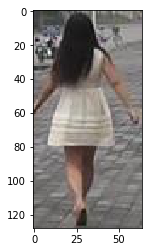

In [87]:
plt.imshow(np.rollaxis(object_img, 0, 3));

In [92]:
result = result[1][0:10]

In [96]:
images = []
for token in result:
    images.append(test_features[token[2]][2])

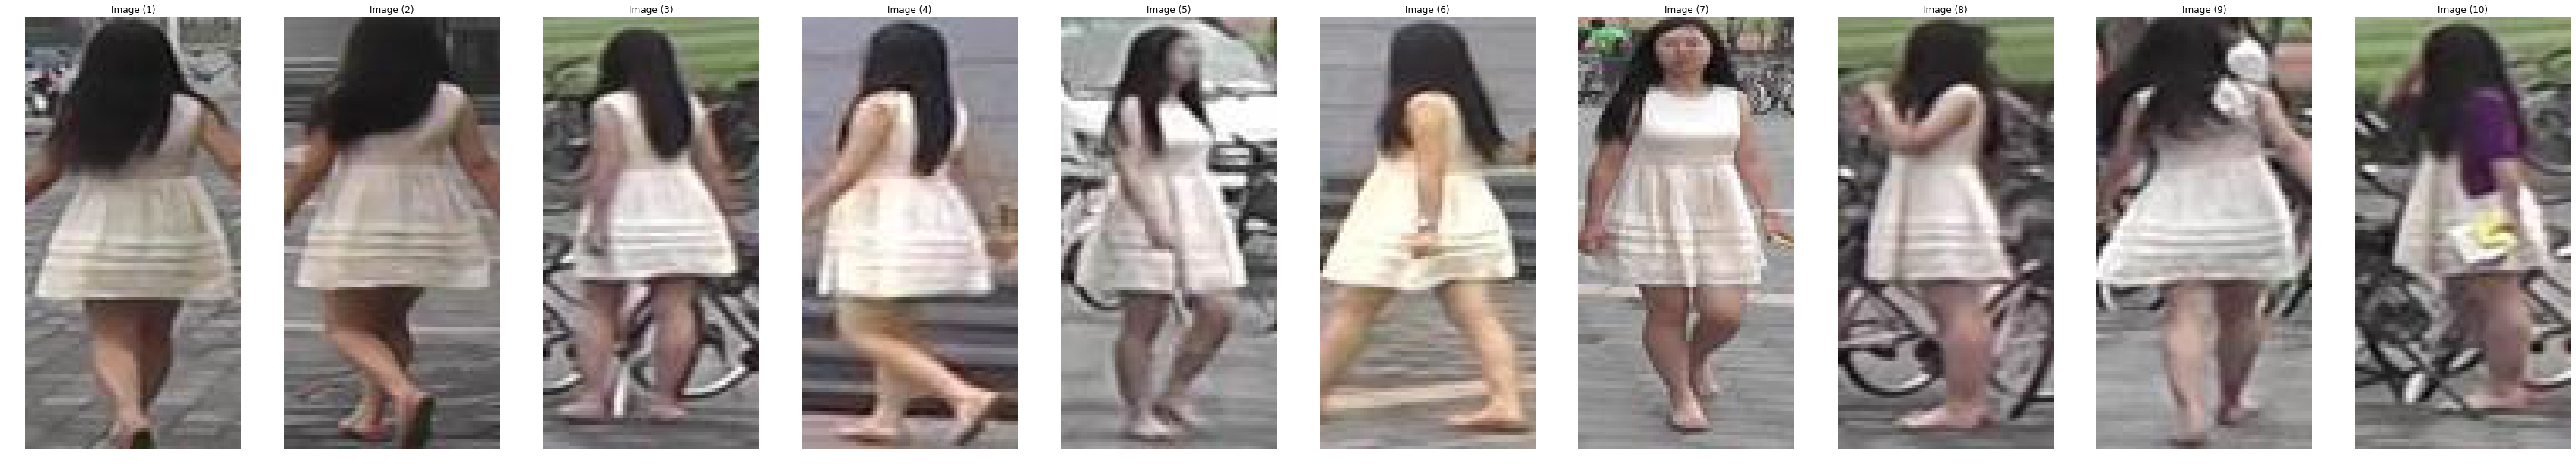

In [98]:
show_images(images=images)

In [99]:
result = find_distance_one(object_with_features=query_features[256],test_features=test_features)

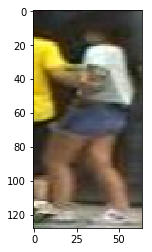

In [101]:
object_img = query_features[256][2]
plt.imshow(np.rollaxis(object_img, 0, 3));

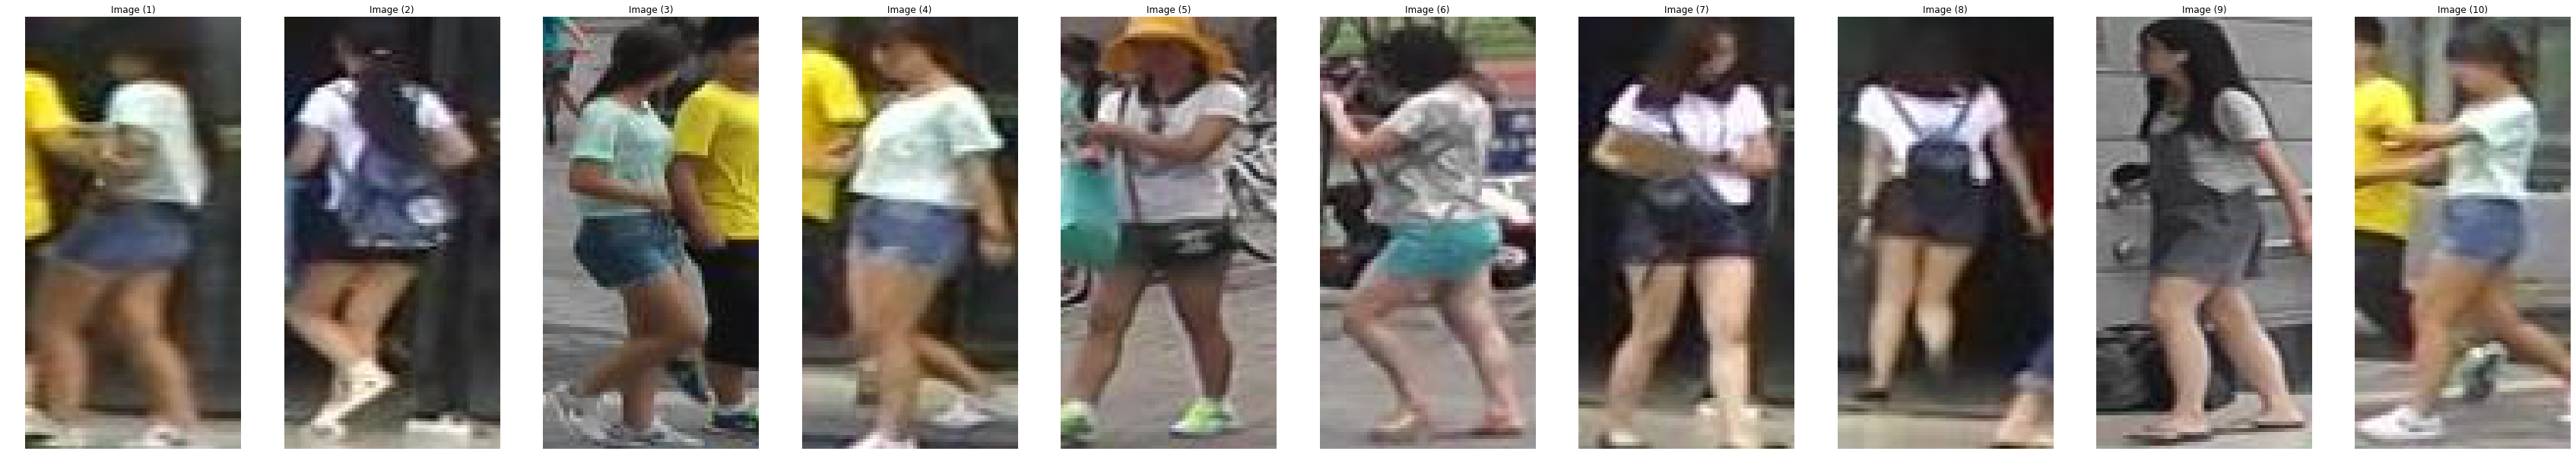

In [102]:
images = []
for token in result[1][0:10]:
    images.append(test_features[token[2]][2])
show_images(images=images)

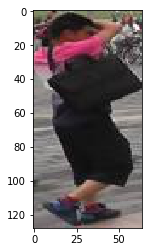

In [110]:
object_img = query_features[2024][2]
plt.imshow(np.rollaxis(object_img, 0, 3));

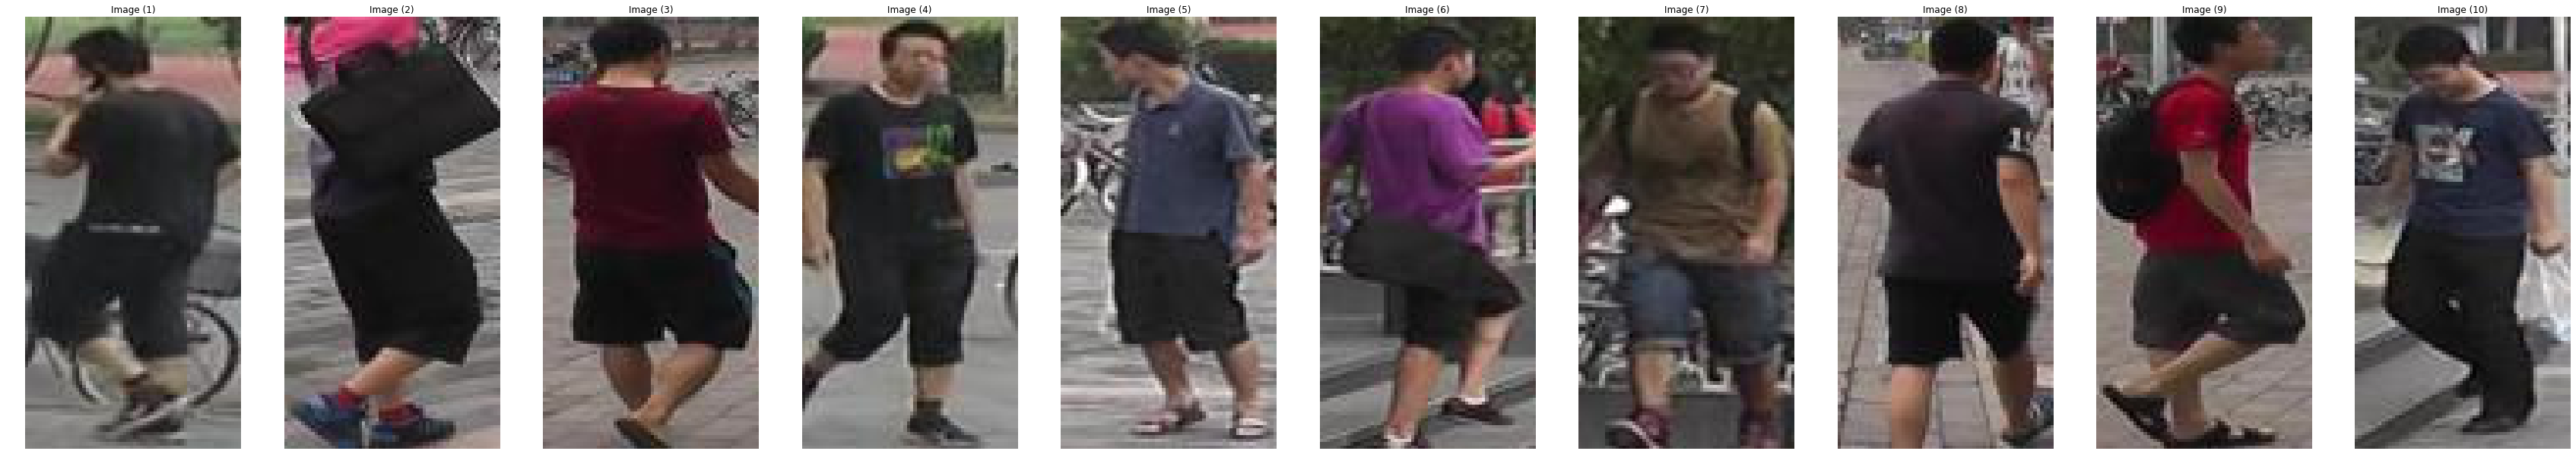

In [109]:
result = find_distance_one(object_with_features=query_features[2024],test_features=test_features)
images = []
for token in result[1][0:10]:
    images.append(test_features[token[2]][2])
show_images(images=images)

In [97]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(np.rollaxis(image, 0, 3));
        #plt.imshow(image)
        plt.axis('off') # add by moheo
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
plt.show()